In [8]:
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
BASE_PATH = 'data'
IMG_SHP = (66, 200, 3)

In [54]:
class ImageProcessor(object):

    @classmethod
    def preprocess_image(cls, image):
        """
        Preprocess image:
        1. Crop image: remove unrelated protion of the image
                       (e.g. hood, everything above the road surface)
        2. Scale image: to reduce calculation
        3. Change color space
        """
        image = image[60:145, 40:280]

        image = cv2.resize(image, (IMG_SHP[1], IMG_SHP[0]), interpolation=cv2.INTER_AREA)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2YUV)

        return image

    @classmethod
    def augment_data(cls, img, y):
        """
        https://chatbotslife.com/using-augmentation-to-mimic-human-driving-496b569760a9
        """
        img, y = cls.shift_image(img, y)
        img, y = cls.flip_image(img, y)

        img = cls.change_brightness(img)
        img = cls.add_shadow(img)

        return img, y

    @classmethod
    def choose_image(cls, record, y, delta=.27, idx=None):
        """
        Side cameras : simulate driving off center
        """
        delta = [delta, 0, -delta]
        image = [record.left_image,
                 record.center_image,
                 record.right_image]

        if idx is None:
            idx = np.random.randint(3)
        return image[idx], y + delta[idx]

    @classmethod
    def perturb_angle(cls, angle):
        """
        https://medium.com/@acflippo/cloning-driving-behavior-by-augmenting-steering-angles-5faf7ea8a125#.9qo2nhv3o
        """
        delta = 0.01
        return angle * np.random.uniform(1-delta, 1+delta)

    @classmethod
    def shift_image(cls, img, y):
        """
        Shift: simulate different position on the road, up hill, down hill
        """
        if np.random.uniform() > .25:
            return img, y

        max_dx, max_dy = 50, 20
        dx = np.random.uniform(-max_dx, max_dx)
        dy = np.random.uniform(-max_dy, max_dy)
        y += dx / max_dx * .2

        M = np.float32([[1, 0, dx], [0, 1, dy]])
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))

        return img, y

    @classmethod
    def flip_image(clsf, img, y, random=True):
        """
        Flip: simulate different side (direction) of the road
        """
        if not random or np.random.randint(2):
            img = cv2.flip(img, 1)
            y = -y
        return img, y

    @classmethod
    def change_brightness(cls, img, factor=None):
        """
        Brightness: simulate different time in the day
        """
        factor = factor or np.random.uniform(0.15, 1.2)
        img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        img[:,:,2] = (img[:,:,2] * factor).astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_HSV2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        return img

    @classmethod
    def add_shadow(cls, img):
        """
        Shadow: simulate shadow cast on the road
        """
        rows, cols, _ = img.shape
        top_x = 0
        top_y = np.random.uniform(cols)

        bot_x = rows
        bot_y = np.random.uniform(cols)

        img = cv2.cvtColor(img, cv2.COLOR_YUV2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

        X_m, Y_m = np.mgrid[0:rows,0:cols]
        mask = np.zeros_like(img[:,:,1])
        mask[(  X_m - top_x)*(bot_y - top_y) -
             (bot_x - top_x)*(  Y_m - top_y) >= 0] = 1

        bright = np.random.uniform(0.15, 0.95)
        mask = (mask == np.random.randint(2))
        img[:,:,1][mask] = img[:,:,1][mask] * bright

        img = cv2.cvtColor(img, cv2.COLOR_HLS2BGR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
        return img

In [5]:
class ImageRecord(object):
    """ A data structure to load and hold image record. """

    IMG_PATH = BASE_PATH

    def __init__(self, meta):

        self.steering = float(meta.get('steering') or 0)
        self.throttle = float(meta.get('throttle') or 0)
        self.speed    = float(meta.get('speed') or 0)
        self.brake    = float(meta.get('brake') or 0)

        self.left_path   = os.path.join(self.IMG_PATH,
                                        meta.get('left').strip())
        self.center_path = os.path.join(self.IMG_PATH,
                                        meta.get('center').strip())
        self.right_path  = os.path.join(self.IMG_PATH,
                                        meta.get('right').strip())

        self._left_image   = None
        self._center_image = None
        self._right_image  = None

    @property
    def left_image(self):
        if self._left_image is None:
            self._left_image = self.load_image(self.left_path)
        return self._left_image

    @property
    def center_image(self):
        if self._center_image is None:
            self._center_image = self.load_image(self.center_path)
        return self._center_image

    @property
    def right_image(self):
        if self._right_image is None:
            self._right_image = self.load_image(self.right_path)
        return self._right_image

    def load_image(self, path):
        image = cv2.imread(path)
        if image is None:
            print('Failed to load image : {}'.format(path))
        return image

    def __str__(self):
        output = ''
        output += 'Steering: {}\n'.format(self.steering)
        output += 'Throttle: {}\n'.format(self.throttle)
        output += 'Speed: {}\n'.format(self.speed)
        output += 'Brake: {}\n'.format(self.brake)
        output += '\n'
        output += 'Left camera image path: {}\n'.format(self.left_path)
        output += 'Center camera image path: {}\n'.format(self.center_path)
        output += 'Right camera image path: {}\n'.format(self.right_path)
        output += '\n\n'
        return output


class BaseImageDataset(object):
    """ A data structure to hold a set of records. """

    def __init__(self, test_size=0.1):

        self.SIZE_SCALE = 1

        self.X_train = None
        self.y_train = None
        self._X_train = None
        self._y_train = None
        self.train_size = 0

        self.X_validate = None
        self.y_validate = None
        self._X_validate = None
        self._y_validate = None
        self.validation_size = 0

        self._test_size = test_size

        self.load_data()

    @property
    def log_path(self):
        if not hasattr(self, 'LOG_PATH'):
            raise NotImplementedError

        return self.LOG_PATH

    @property
    def test_size(self):
        return self._test_size

    @property
    def image_shape(self):
        if self._X_train is None:
            return None
        return self._X_train[0].center_image.shape

    def load_data(self):
        """
        """
        df = pd.read_csv(self.LOG_PATH)

        X_train = []
        y_train = []

        # load data from log
        for _, data in df.iterrows():
            record = ImageRecord(data)
            X_train.append(record)
            y_train.append(record.steering)

        # split data
        X_train, X_validate, y_train, y_validate = train_test_split(
                X_train, y_train, test_size=self.test_size)

        self._X_train = X_train
        self._y_train = y_train
        self.train_size = len(X_train) * self.SIZE_SCALE

        self._X_validate = X_validate
        self._y_validate = y_validate
        self.validation_size = len(X_validate) * self.SIZE_SCALE


    ##########################################################################
    ## Data
    ##########################################################################
    @property
    def train_data(self):
        if self.X_train is None or self.y_train is None:
            self.X_train, self.y_train = \
                    self.process_data(self._X_train, self._y_train)
        return self.X_train, self.y_train

    @property
    def validation_data(self):
        if self.X_validate is None or self.y_validate is None:
            self.X_validate, self.y_validate = \
                    self.process_data(self._X_validate, self._y_validate)
        return self.X_validate, self.y_validate

    def process_data(self, raw_X, raw_y, skip_rate=0.2, center_only=False):
        X, y = [], []

        i_range = [1] if center_only else range(3)

        for rec, out in zip(raw_X, raw_y):
            for i in i_range:
                img, new_out = ImageProcessor.choose_image(rec, out, idx=i)
                img          = ImageProcessor.preprocess_image(img)
                img, new_out = ImageProcessor.augment_data(img, new_out)

                if abs(new_out) > 0.1 or np.random.uniform() > skip_rate:
                    X.append(img)
                    y.append(new_out)

                if abs(new_out) > 0.1:
                    img, new_out = ImageProcessor.flip_image(img, new_out, random=False)
                    X.append(img)
                    y.append(new_out)

        #shuffled_indexes = np.arange(len(X))
        #shffuled_indexes = np.random.shuffle(shuffled_indexes)
        #return np.array(X)[shuffled_indexes], np.array(y)[shuffled_indexes]
        return np.array(X), np.array(y)

In [6]:
class UdacityDataset(BaseImageDataset):

    LOG_PATH = os.path.join(BASE_PATH, 'driving_log.csv')

In [9]:
ds = UdacityDataset()
train_data = ds.train_data[1]
val_data = ds.validation_data[1]

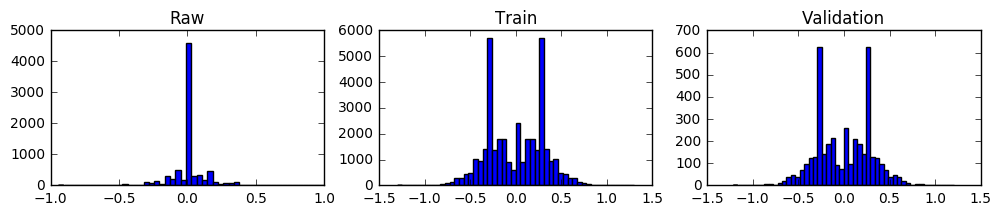

In [32]:
df = pd.read_csv(ds.LOG_PATH)

fig = plt.figure(figsize=(12, 2)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

ax0 = plt.subplot(gs[0])
ax0.hist(df.steering, bins=50)
ax0.set_title('Raw')

ax1 = plt.subplot(gs[1])
ax1.hist(train_data, bins=50)
ax1.set_title('Train')

ax2 = plt.subplot(gs[2])
ax2.hist(val_data, bins=50)
ax2.set_title('Validation')

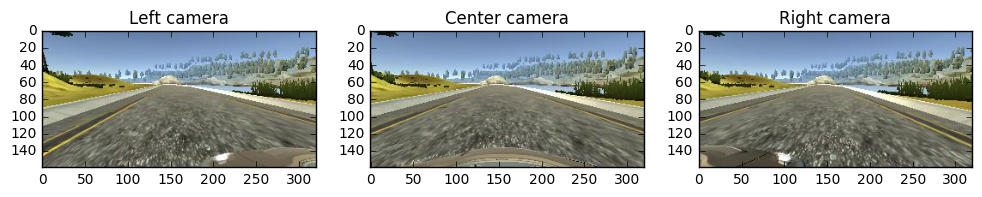

In [56]:
from matplotlib import gridspec

rec = ds._X_train[0]
center = cv2.cvtColor(rec.center_image, cv2.COLOR_BGR2RGB)
left = cv2.cvtColor(rec.left_image, cv2.COLOR_BGR2RGB)
right = cv2.cvtColor(rec.right_image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 6)) 
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

for ax, img, title in zip(gs, [left, center, right], ['Left camera', 'Center camera', 'Right camera']):
    ax = plt.subplot(ax)
    ax.imshow(img)
    ax.set_title(title)

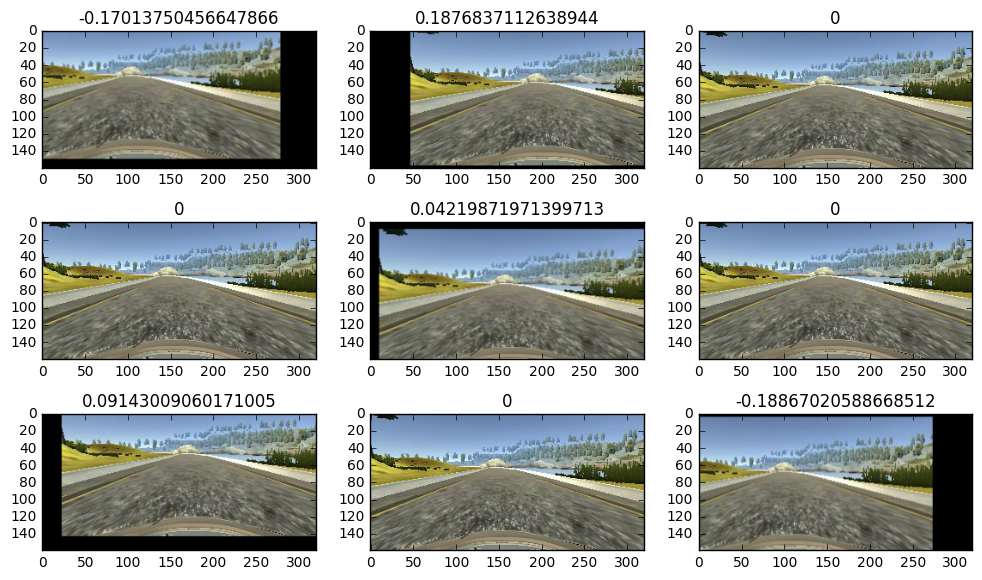

In [55]:
img, y = center, 0

new_imgs, new_ys = [], []
for _ in range(9):
    new_img, new_y = ImageProcessor.shift_image(img, y)
    new_imgs.append(new_img)
    new_ys.append(new_y)

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1])

for ax, img, y in zip(gs, new_imgs, new_ys):
    ax = plt.subplot(ax)
    ax.imshow(img)
    ax.set_title(y)

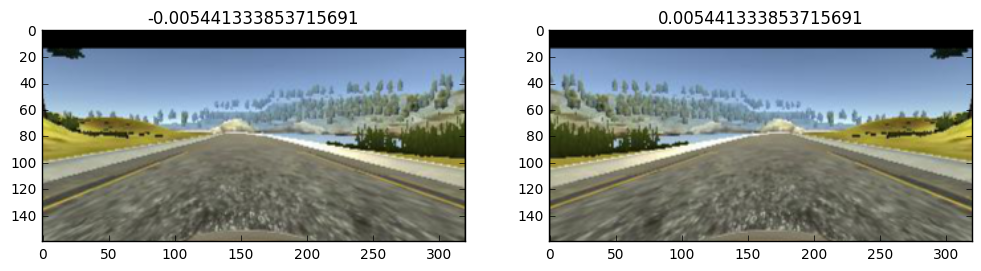

In [39]:
img, y = center, 0
new_imgs, new_ys = [], []
new_imgs.append(img)
new_ys.append(y)
new_img, new_y = ImageProcessor.flip_image(img, y)
new_imgs.append(new_img)
new_ys.append(new_y)

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

for ax, img, y in zip(gs, new_imgs, new_ys):
    ax = plt.subplot(ax)
    ax.imshow(img)
    ax.set_title(y)

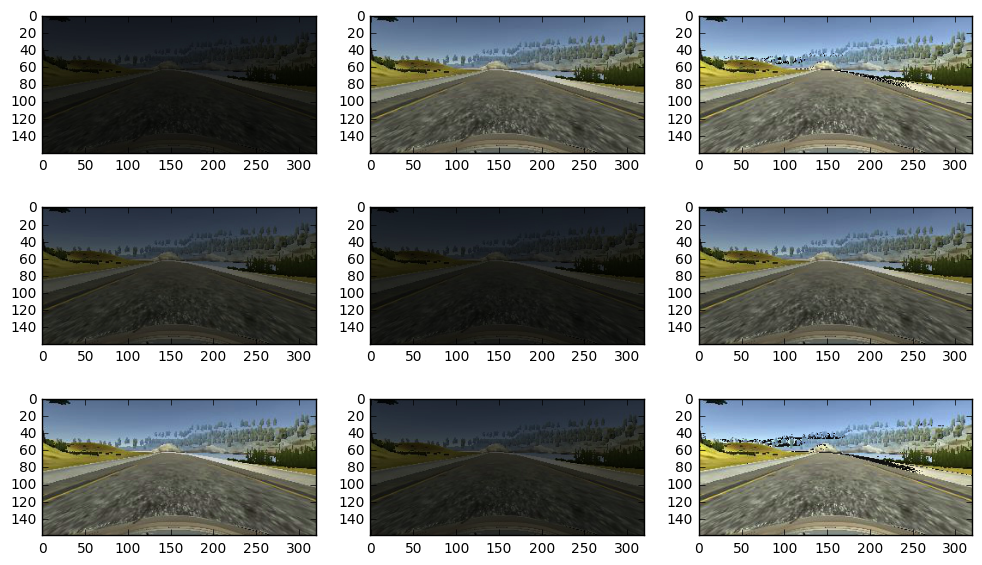

In [52]:
img, y = rec.center_image, 0
new_imgs = []
for _ in range(9):
    new_img = ImageProcessor.change_brightness(cv2.cvtColor(img, cv2.COLOR_BGR2YUV))
    new_imgs.append(new_img)

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1])

for ax, img in zip(gs, new_imgs):
    ax = plt.subplot(ax)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_YUV2RGB))

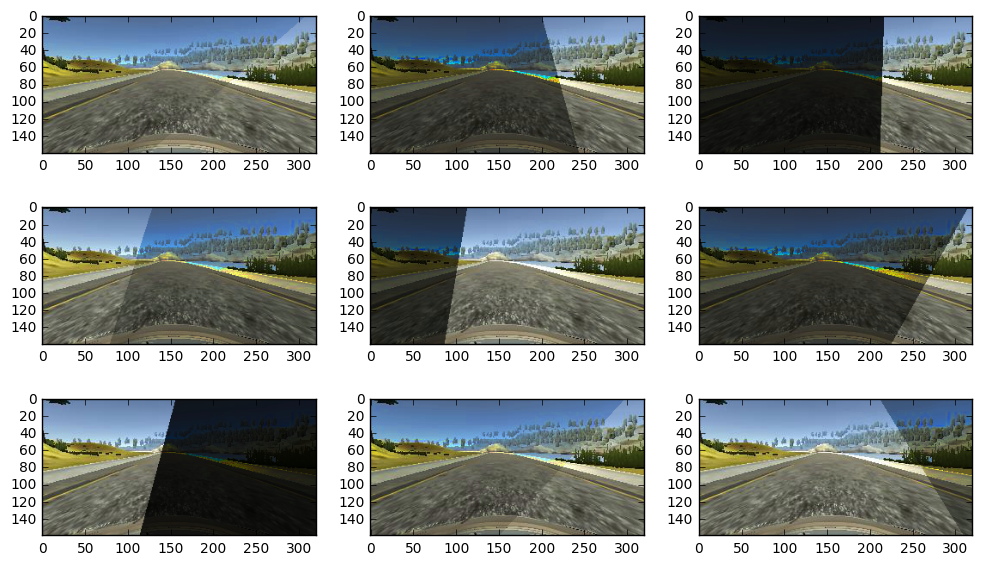

In [53]:
img, y = rec.center_image, 0
new_imgs = []
for _ in range(9):
    new_img = ImageProcessor.add_shadow(cv2.cvtColor(img, cv2.COLOR_BGR2YUV))
    new_imgs.append(new_img)

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(3, 3, width_ratios=[1, 1, 1])

for ax, img in zip(gs, new_imgs):
    ax = plt.subplot(ax)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_YUV2RGB))

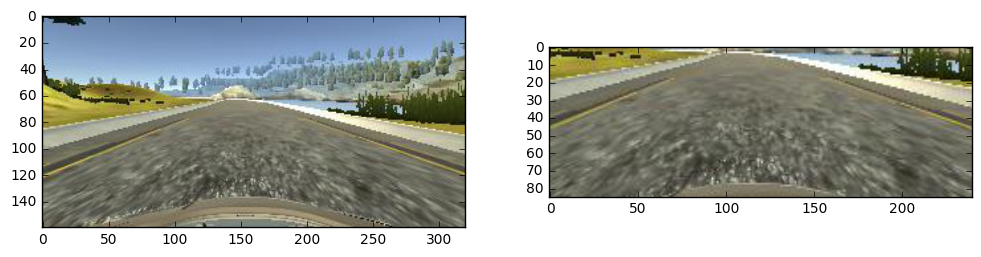

In [62]:
img = rec.center_image
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

new_img = img[60:145, 40:280]
new_imgs = [img, new_img]

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

for ax, img, y in zip(gs, new_imgs, new_ys):
    ax = plt.subplot(ax)
    ax.imshow(img)

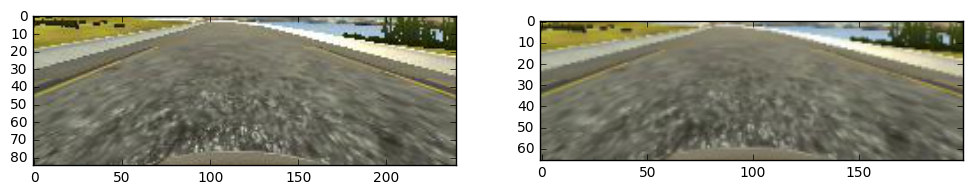

In [63]:
img = new_img
new_img = cv2.resize(img, (200, 66), interpolation=cv2.INTER_AREA)

new_imgs = [img, new_img]

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

for ax, img, y in zip(gs, new_imgs, new_ys):
    ax = plt.subplot(ax)
    ax.imshow(img)

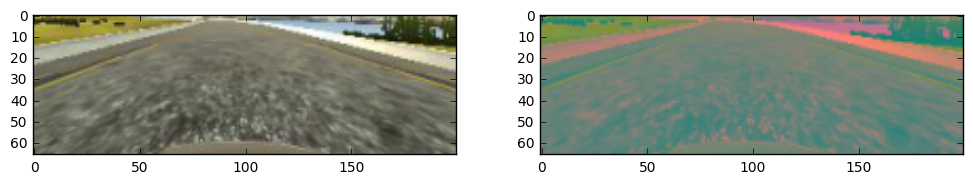

In [64]:
img = new_img
new_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
new_imgs = [img, new_img]

fig = plt.figure(figsize=(12, 7)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

for ax, img, y in zip(gs, new_imgs, new_ys):
    ax = plt.subplot(ax)
    ax.imshow(img)